In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as T
import scipy.stats as stats

## The problem

The data is just a collection of 300 numbers, but the histogram appears bimodal, suggesting the values are from two distributions. Is this a valid assumption?

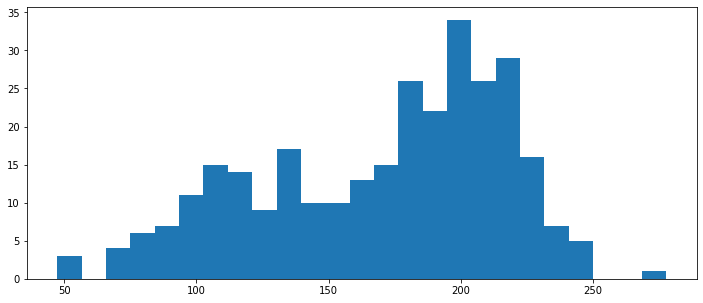

In [2]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")
data_size=len(data)
plt.figure(figsize=(12,5))
plt.hist(data, bins=25);

## 1. Designing the data generation scheme

*...propose how the data might have been generated*

* Assume that, when we draw a data point, it has probability $p_0$ of coming from the first cluster and $p_1=1-p_0$ of coming from the other.
* Model each cluster as a normal distribution with $\mu_i$ and $\sigma_i$ (where $i$ is $0$ for the first cluster, $1$ for the second cluster)

We don't know anything about $p_0$ and $p_1$ so let's assign them a uniform prior...

$$p_0 \sim \text{Uniform}(\mathit{lower}=0.0,~\mathit{upper}=1.0)$$
$$p_1=1-p_0$$

$$\text{cluster_assignment} \sim \text{Categorical}(\mathit{p}=[p_0,p_1])$$

Similarly, we don't need to make any assumptions about the $\sigma$s of each distribution. Let's say a uniform distribution over 0-100...

$$\text{sds} \sim \text{Uniform}(\mathit{lower}=0.0,~\mathit{upper}=100.0)$$

But we can probably make a guess at the values for $\mu_0$ & $\mu_1$. We could say they're around $120$ and $200$ respectively and to incorporate our uncertainty about these eyeballed guesses we could model them as normal distributions themselves...

$$\text{mus} \sim \text{Normal}(\mathit{mu}=[120,200],~\mathit{sigma}=[10,10])$$


**Notes:**

* `theano.tensor.stack` turns an array into something that Theano can work with.
* `pymc3.Categorical` makes a stochastic variable for choosing from a list of possibilities each with relative probabilities (summing to 1).
* Like before, the `cluster_assignment` test value is initialised by randomly selecting an integer $0$ or $1$ 300 times. (If we don't do this, it will be initialised with all 0s - i.e., all data points from the first cluster - so we're just giving a more realistic starting point!)

In [3]:
with pm.Model() as model:
    p0=pm.Uniform('p0',0,1)
    p1=1-p0
    p=T.stack([p0, p1])
    cluster_assignment=pm.Categorical("cluster_assignment", p,
                                      shape=data_size,
                                      testval=np.random.randint(0,2,data_size))
    
    sds=pm.Uniform('sds',0,100,shape=2)
    mus=pm.Normal("mus", mu=np.array([120,200]), sd=np.array([10,10]), shape=2)
    
    mu=pm.Deterministic('mu', mus[cluster_assignment])
    sd=pm.Deterministic('sd', sds[cluster_assignment])

## 2. Associate the data generation scheme with the actual observed data

In [4]:
with model:
    observations=pm.Normal('observations', mu=mu, sd=sd, observed=data)

Notice that, by specifying `mu` & `sd` deterministic variables from the other variables, we end up with starting test values of centers either $120$ or $200$ depending on the initial random cluster assignments...

In [5]:
print('Random assignments: ', cluster_assignment.tag.test_value[:10], '...')
print('Assignmented center: ', mu.tag.test_value[:10], '...')
print('Assignmented SD: ', sd.tag.test_value[:10], '...')

Random assignments:  [0 0 0 0 0 0 1 0 1 1] ...
Assignmented center:  [120. 120. 120. 120. 120. 120. 200. 120. 200. 200.] ...
Assignmented SD:  [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.] ...


## 3. Run the black-box algorithm (that we're about to open up a little)

To tell the model how to explore the space we have to define the appropriate sample methods to use. In this case `Metropolis` for the continuous variables and `ElemwiseCategorical` for the categorical variable. (I'm not sure what each of these are yet, or what other methods there might be, or how you choose the appropriate one.)

Then use these sampling methods together with a number of iterations to get samples ("traces") from the space, which are stored in `trace`. (I'm guessing the samples/traces are all points that pass the "is this point in the 'mountain'" test, and they're what we can use to reconstruct the 'mountain'!)

In [6]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, mus])
    step2 = pm.ElemwiseCategorical(vars=[cluster_assignment])
    trace = pm.sample(25000, step=[step1, step2])

C:\Dev\bitbucket-personal\bayes-hackers\conda-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mus]
>>Metropolis: [sds]
>>Metropolis: [p0]
>ElemwiseCategorical: [cluster_assignment]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████| 102000/102000 [05:56<00:00, 285.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


The `trace` variable stores all the samples. They're indexed by the name we used when creating the random variables, e.g., `trace['sds']`.

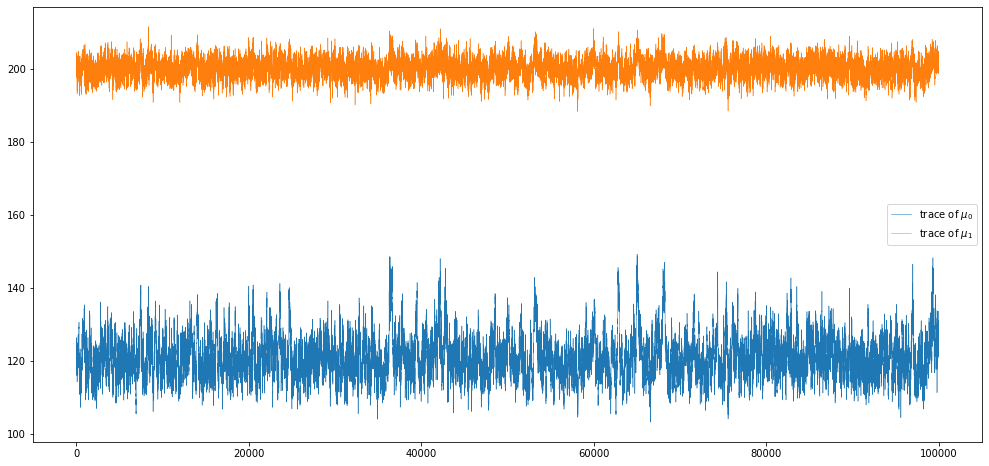

In [7]:
# trace['mus'].shape is (100000, 2) cos we defined it from 2x normal distributions (shape=2)

plt.figure(figsize=(17,8))
plt.plot(trace['mus'][:100000, 0], label='trace of $\mu_0$', lw=0.5)
plt.plot(trace['mus'][:100000, 1], label='trace of $\mu_1$', lw=0.5)
plt.legend();

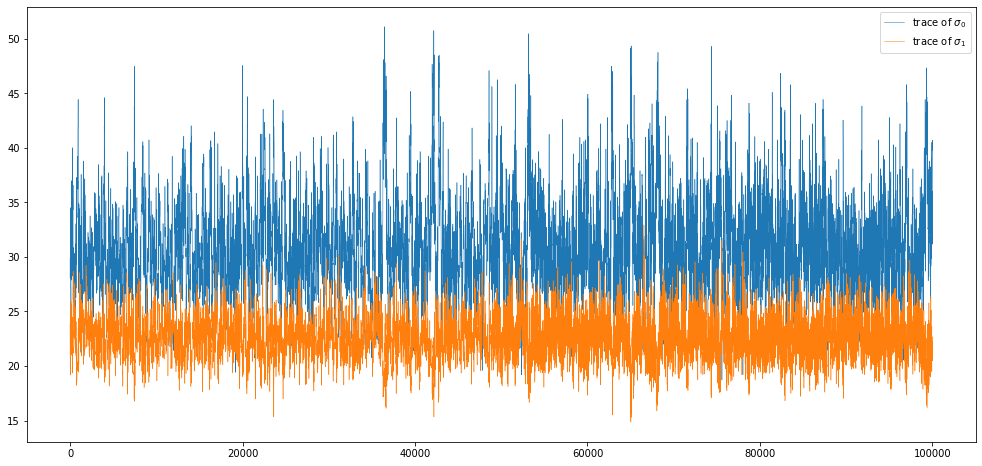

In [8]:
plt.figure(figsize=(17,8))
plt.plot(trace['sds'][:100000, 0], label='trace of $\sigma_0$', lw=0.5)
plt.plot(trace['sds'][:100000, 1], label='trace of $\sigma_1$', lw=0.5)
plt.legend();

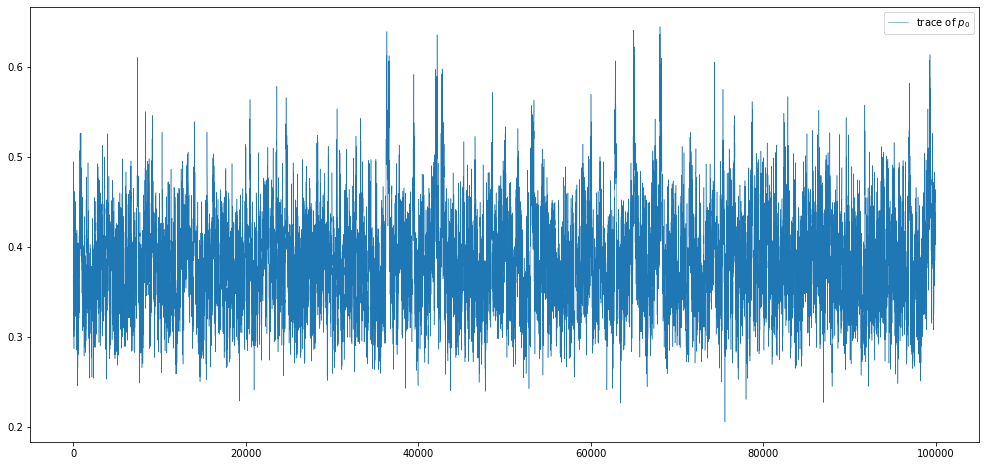

In [9]:
plt.figure(figsize=(17,8))
plt.plot(trace['p0'][:100000], label='trace of $p_0$', lw=0.5)
plt.legend();

Notice that:

* The traces "converge" to a *distribution* of points (not a single point)
* You can see that the first few thousands points might not be part of the converged distribution. (They're often discarded for this reason - it's the *burn-in period*)

Because the MCMC algorithm has no "memory" of where it's been (the only point that matters is the current point), we can continue where we left off to see if we get a "better" convergence by passing our `trace` back into the `sample` function...

In [10]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mus]
>>Metropolis: [sds]
>>Metropolis: [p0]
>ElemwiseCategorical: [cluster_assignment]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████| 202000/202000 [11:48<00:00, 285.16draws/s]
The number of effective samples is smaller than 10% for some parameters.


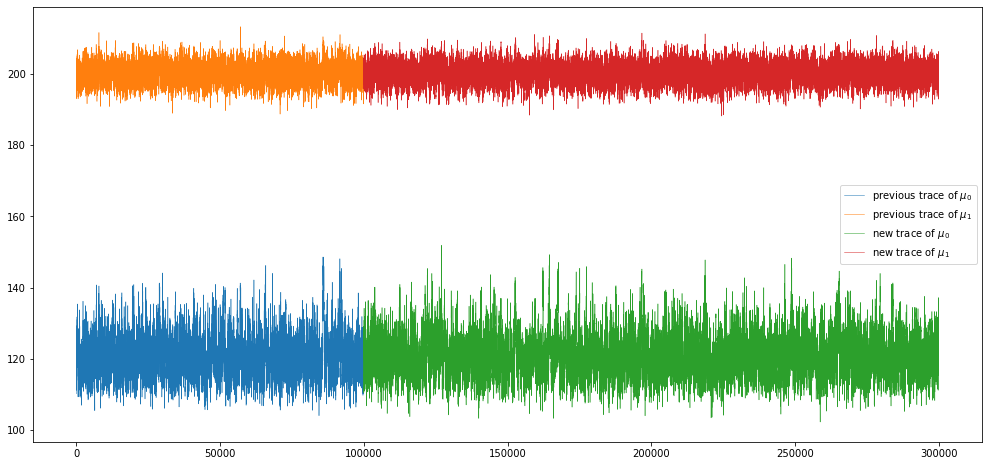

In [11]:
plt.figure(figsize=(17,8))

x=np.arange(100000)
plt.plot(x, trace['mus'][:100000, 0], label='previous trace of $\mu_0$', lw=0.5)
plt.plot(x, trace['mus'][:100000, 1], label='previous trace of $\mu_1$', lw=0.5)

x=np.arange(100000, 300000)
plt.plot(x, trace['mus'][100000:, 0], label='new trace of $\mu_0$', lw=0.5)
plt.plot(x, trace['mus'][100000:, 1], label='new trace of $\mu_1$', lw=0.5)
plt.legend(loc='center right');

## 4. Investigate and interpret the posterior distribution

The histograms of the samples reconstructs the posterior distribution of the unknowns (optionally skipping the "burn-in" period)

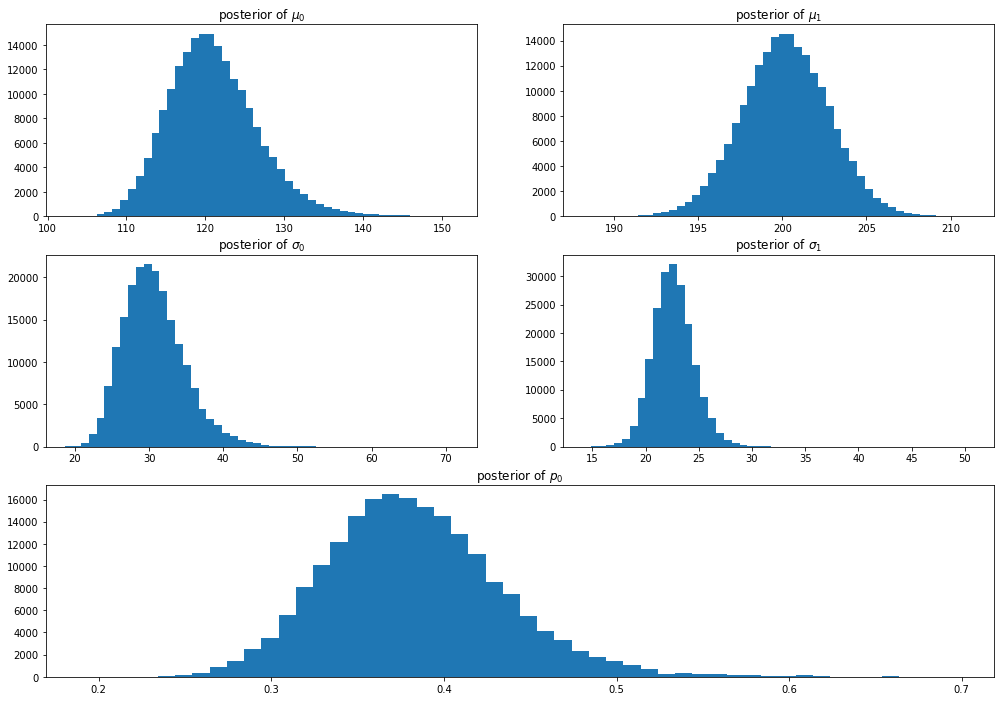

In [12]:
plt.figure(figsize=(17,12))

plt.subplot(321)
plt.hist(trace['mus'][100000:, 0], bins=50)
plt.title('posterior of $\mu_0$')

plt.subplot(322)
plt.hist(trace['mus'][100000:, 1], bins=50)
plt.title('posterior of $\mu_1$')

plt.subplot(323)
plt.hist(trace['sds'][100000:, 0], bins=50)
plt.title('posterior of $\sigma_0$')

plt.subplot(324)
plt.hist(trace['sds'][100000:, 1], bins=50)
plt.title('posterior of $\sigma_1$')

plt.subplot(313)
plt.hist(trace['p0'][100000:], bins=50)
plt.title('posterior of $p_0$');

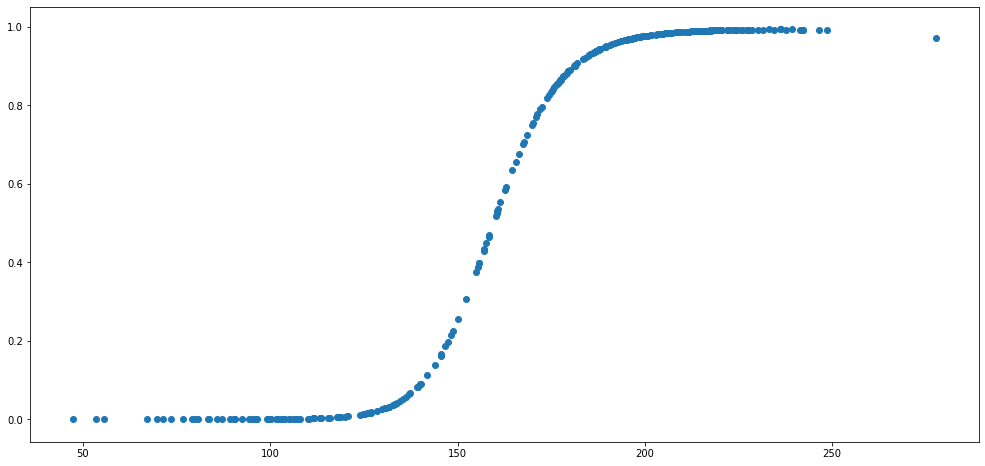

In [13]:
# trace['cluster_assignment'].shape = (300000, 300)
# ...each sample is 300 assignments (0 or 1) indicating whether each data point was assigned to cluster 0 or 1
# ...the mean of each sample is then the probability that each data point belongs to cluster 1

mean_assignments = trace['cluster_assignment'].mean(axis=0)
plt.figure(figsize=(17,8))
plt.scatter(data, mean_assignments);

## Predicting the cluster from a new value

New value $x=175$ - which cluster would we predict it belonged to? Actually need to answer, is $P(L_x=1|x=175)>P(L_x=0|x=175)$?

Using Bayes Theorem...

$P(L_x=c|x=v)=\cfrac{P(x=v|L_x=c)P(L_x=c)}{P(x=v)}$

$\cfrac{P(x=175|L_x=1)P(L_x=1)}{P(x=175)} \gt \cfrac{P(x=175|L_x=0)P(L_x=0)}{P(x=175)}$

We can ignore the denominators as they're both the same...

$P(x=175|L_x=1)P(L_x=1) \gt P(x=175|L_x=0)P(L_x=0)$

...which we can calculate using the posteriors from the model.

* $P(L_x=0)$ is 'p0' in our model (and $P(L_x=1)$ is, by definition, $1-p_0$)
* $P(x=175|L_x=0)$ and $P(x=175|L_x=1)$ can be thought of as the probability of the value $175$ from each normal distribution with $\mu_0, \sigma_0$ and $\mu_1, \sigma_1$ respectively from our model
* The calculation is actually, for all the samples in the traces, calculate the probabilities and count the number of times $P(x=175|L_x=1)P(L_x=1) \gt P(x=175|L_x=0)P(L_x=0)$. We take $P(L_x=0|x=175)$ as the mean of this. (It seems the best approach is to work with the samples as long as possible and average at the end - rather than calculating the averages of the samples.)

In [14]:
p175L0 = stats.norm.pdf(175, loc=trace['mus'][100000:, 0], scale=trace['sds'][100000:, 0])
p175L1 = stats.norm.pdf(175, loc=trace['mus'][100000:, 1], scale=trace['sds'][100000:, 1])

p0 = trace['p0'][100000:]
p1 = 1-p0

(p175L0*p0 > p175L1*p1).mean()

0.01189

## Using MAP as a starting point

In [15]:
with model:
    start = pm.find_MAP()
    trace_from_MAP = pm.sample(100000, step=[step1, step2], start=start)

logp = -1,811.4, ||grad|| = 0.0016693: 100%|████████████████████████████████████████| 33/33 [00:00<00:00, 916.79it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [mus]
>>Metropolis: [sds]
>>Metropolis: [p0]
>ElemwiseCategorical: [cluster_assignment]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████| 402000/402000 [27:42<00:00, 241.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [33]:
burned_trace=trace_from_MAP[50000:]

## Built-in plots

C:\Dev\bitbucket-personal\bayes-hackers\conda-env\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Dev\bitbucket-personal\bayes-hackers\conda-env\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Dev\bitbucket-personal\bayes-hackers\conda-env\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Dev\bitbucket-personal\bayes-hackers\conda-env\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument b

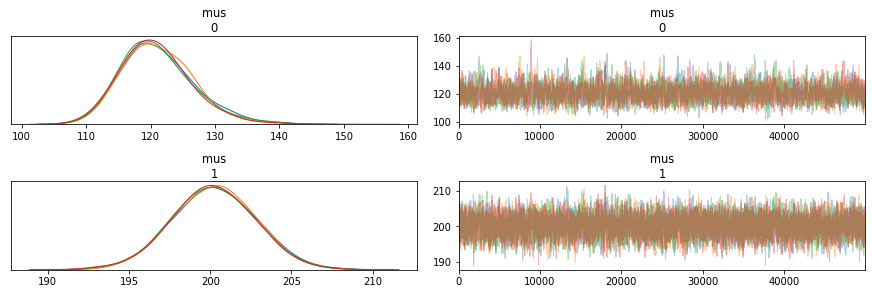

In [49]:
pm.plots.plot_trace(burned_trace, var_names=['mus']);

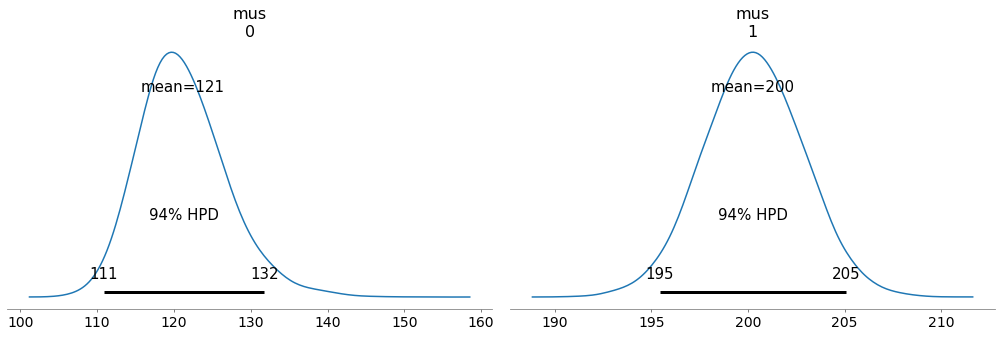

In [50]:
pm.plots.plot_posterior(burned_trace, var_names=['mus']);

The interval marked by the horizontal black line overlay represents the 94% highest posterior density interval. It can be interpreted as "there is a 94% chance the parameter of interest lies in this interval".